## NREL National Climate Database (NCDB) - HSDS Demo

This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Climate Database (NCDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS).

For this to work you must first install h5pyd:

```
pip install --user h5pyd
```

Next you'll need to configure HSDS:

```
hsconfigure
```

and enter at the prompt:

```
hs_endpoint = https://developer.nrel.gov/api/hsds
hs_username = None
hs_password = None
hs_api_key = 3K3JQbjZmWctY0xmIfSYvYgtIcM3CN0cb1Y2w9bf
```

*The example API key here is for demonstation and is rate-limited per IP. To get your own API key, visit https://developer.nrel.gov/signup/*

You can also add the above contents to a configuration file at ~/.hscfg

In [1]:
%matplotlib inline
import h5pyd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NCDB is provided in annual .h5 files and currently spans 2006-2100. 

The RCP4.5 can be accessed from:
  /nrel/ncdb/4km-Hourly-CONUS/v1.0.0/RCP4.5/ncdb_rcp4.5_${year}.h5

The RCP8.5 can be accessed from: 
  /nrel/ncdb/4km-Hourly-CONUS/v1.0.0/RCP8.5/ncdb_rcp8.5_${year}.h5

In [2]:
# Open the desired year of ncdb data
# server endpoint, username, password is found via a config file
f = h5pyd.File("/nrel/ncdb/4km-Hourly-CONUS/v1.0.0/RCP4.5/ncdb_rcp4.5_2006.h5", 'r')

## Datasets

In [3]:
list(f)  # list the datasets in the file

['air_temperature',
 'air_temperature_percent_change',
 'air_temperature_raw_change',
 'dhi',
 'dhi_percent_change',
 'dhi_raw_change',
 'dni',
 'dni_percent_change',
 'dni_raw_change',
 'ghi',
 'ghi_percent_change',
 'ghi_raw_change',
 'meta',
 'solar_zenith_angle',
 'time_index',
 'wind_speed',
 'wind_speed_percent_change',
 'wind_speed_raw_change']

In [4]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(8760, 522485)

In [5]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 60min

DatetimeIndex(['2006-01-01 00:00:00+00:00', '2006-01-01 01:00:00+00:00',
               '2006-01-01 02:00:00+00:00', '2006-01-01 03:00:00+00:00',
               '2006-01-01 04:00:00+00:00', '2006-01-01 05:00:00+00:00',
               '2006-01-01 06:00:00+00:00', '2006-01-01 07:00:00+00:00',
               '2006-01-01 08:00:00+00:00', '2006-01-01 09:00:00+00:00',
               ...
               '2006-12-31 14:00:00+00:00', '2006-12-31 15:00:00+00:00',
               '2006-12-31 16:00:00+00:00', '2006-12-31 17:00:00+00:00',
               '2006-12-31 18:00:00+00:00', '2006-12-31 19:00:00+00:00',
               '2006-12-31 20:00:00+00:00', '2006-12-31 21:00:00+00:00',
               '2006-12-31 22:00:00+00:00', '2006-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq=None)

In [6]:
# Locational information is stored in either 'meta' 
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county
0,48.369999,-124.699997,128,-8,b'United States',b'Washington',b'Clallam'
1,48.169998,-124.699997,50,-8,b'United States',b'Washington',b'Clallam'
2,48.130001,-124.699997,40,-8,b'United States',b'Washington',b'Clallam'
3,48.369999,-124.660004,135,-8,b'United States',b'Washington',b'Clallam'
4,48.330002,-124.660004,36,-8,b'United States',b'Washington',b'Clallam'


In [7]:
# Datasets have been saved as integers
dset.dtype

dtype('uint16')

In [8]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 9 GB per dataset!

9.153937200000001

In [9]:
dset.chunks 

(2000, 500)

In [10]:
dset.chunks[0] * dset.chunks[1] * 2 * 10**-6 # 2 MB per chunk

2.0

In [11]:
# To convert dataset values back to floats use the 'scale_factor'
dset.attrs['scale_factor'] # Irradiance values have been truncated to integer precision

1.0

In [12]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['scale_factor']
units = f['wind_speed'].attrs['units']
print('wind_speed scale factor = ', scale_factor)
print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0
wind_speed units after unscaling =  m/s


1.5

## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [13]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2006-01-01 00:00:00+00:00', '2006-01-01 01:00:00+00:00',
               '2006-01-01 02:00:00+00:00', '2006-01-01 03:00:00+00:00',
               '2006-01-01 04:00:00+00:00', '2006-01-01 05:00:00+00:00',
               '2006-01-01 06:00:00+00:00', '2006-01-01 07:00:00+00:00',
               '2006-01-01 08:00:00+00:00', '2006-01-01 09:00:00+00:00',
               ...
               '2006-12-31 14:00:00+00:00', '2006-12-31 15:00:00+00:00',
               '2006-12-31 16:00:00+00:00', '2006-12-31 17:00:00+00:00',
               '2006-12-31 18:00:00+00:00', '2006-12-31 19:00:00+00:00',
               '2006-12-31 20:00:00+00:00', '2006-12-31 21:00:00+00:00',
               '2006-12-31 22:00:00+00:00', '2006-12-31 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8760, freq=None)

Extract indexes for a particular span of time:

In [14]:
march = time_index.month == 3
np.where(march)[0]

array([1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426,
       1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437,
       1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448,
       1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459,
       1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
       1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481,
       1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492,
       1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503,
       1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514,
       1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525,
       1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536,
       1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547,
       1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558,
       1559, 1560, 1561, 1562, 1563, 1564, 1565, 15

Or a particular date:

In [15]:
timestep = np.where(time_index == '2006-07-04 00:00:00')[0][0]
timestep

4416

## Map Data

In [16]:
# Extract coordinates (lat, lon)
subset_data = f['meta'].read(field=['latitude', 'longitude'])
latitudes = subset_data['latitude']
longitudes = subset_data['longitude']

In [17]:
dset = f['ghi']
%time data = dset[timestep, ::10]   # extract every 10th location at a particular time
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
df['longitude'] = longitudes[::10]
df['latitude'] = latitudes[::10]
df['ghi'] = data / dset.attrs['scale_factor'] # unscale dataset

CPU times: user 3.85 ms, sys: 2.1 ms, total: 5.94 ms
Wall time: 13.6 s


In [18]:
df.shape

(52249, 3)

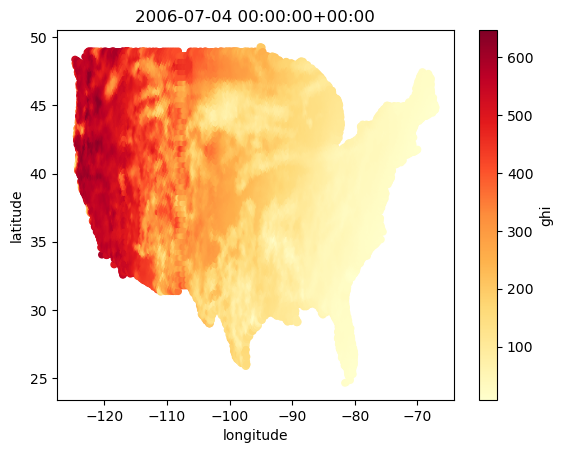

In [19]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [20]:
# Full resolution subset of California
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,elevation,timezone,country,state,county
167,40.490002,-124.379997,158,-8,b'United States',b'California',b'Humboldt'
168,40.450001,-124.379997,160,-8,b'United States',b'California',b'Humboldt'
169,40.410000,-124.379997,281,-8,b'United States',b'California',b'Humboldt'
221,40.570000,-124.339996,60,-8,b'United States',b'California',b'Humboldt'
222,40.529999,-124.339996,201,-8,b'United States',b'California',b'Humboldt'


In [21]:
%time data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['scale_factor']
df.shape

CPU times: user 14.1 ms, sys: 10.2 ms, total: 24.4 ms
Wall time: 13.6 s


(25981, 3)

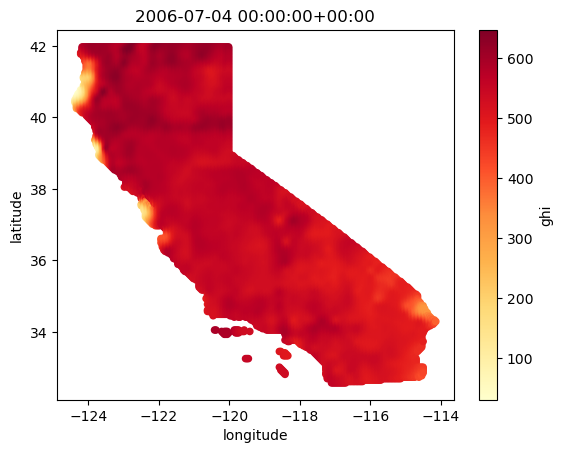

In [22]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

## Nearest Timeseries for given Lat/Lon

In [23]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree
dset_coords = np.column_stack((latitudes, longitudes))
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

Site index for New York City: 		 508721
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 [ 40.73 -74.02]


In [24]:
# Get the entire 2012 timeseries data for a point in NYC
%time tseries = dset[:, NewYorkCity_idx] / dset.attrs['scale_factor']

CPU times: user 4.32 ms, sys: 2.4 ms, total: 6.72 ms
Wall time: 571 ms


In [25]:
len(tseries)   # 1 years * 365 days * 24 hours 

8760

Text(0.5, 1.0, 'NYC ghi in 2006')

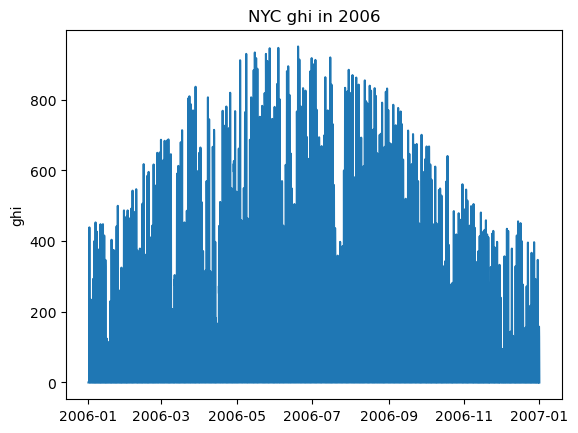

In [26]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("NYC ghi in 2006")

## GHI Statistics

In [27]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,102.580645,191.580645,260.258065,310.935484,321.516129,291.451613,243.387097,146.870968,20.903226,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,304.321429,383.785714,432.750000,449.892857,427.107143,367.107143,278.107143,168.571429,57.428571,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,404.838710,486.290323,538.161290,546.516129,518.451613,460.483871,359.935484,242.451613,114.225806,16.967742
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,416.000000,465.833333,479.333333,475.633333,448.600000,391.600000,321.300000,234.033333,140.466667,49.700000
5,12.548387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,530.225806,606.096774,659.064516,681.741935,655.548387,587.612903,491.451613,369.967742,236.096774,105.290323
6,16.866667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,550.166667,627.333333,669.866667,668.666667,637.466667,574.300000,482.433333,369.300000,240.633333,111.866667
7,15.967742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,511.709677,584.903226,627.000000,639.516129,611.322581,550.548387,456.032258,339.967742,218.548387,101.967742
8,8.387097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,530.870968,630.838710,689.806452,703.419355,670.354839,598.838710,499.548387,364.064516,222.612903,92.806452
9,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,458.633333,537.733333,581.133333,587.366667,556.866667,492.066667,394.700000,275.766667,147.033333,31.333333


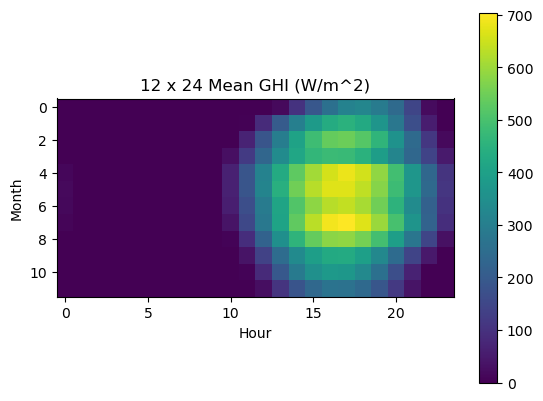

In [28]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()